In [1]:
from keras.datasets import mnist

Using TensorFlow backend.


### Load MNIST data

In [2]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

3


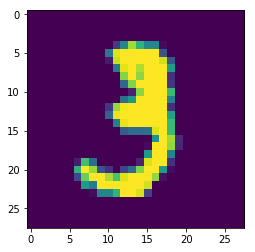

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt 

plt.imshow(X_train[10].reshape(28, 28))
print(y_train[10])

### Convert input MNIST image from 28 * 28 to a flattened 784 

In [13]:
import numpy as np

X_train = X_train.reshape(len(X_train), -1).astype(np.float32)
X_test = X_test.reshape(len(X_test), -1).astype(np.float32)

In [14]:
X_train = X_train/255.
X_test = X_test/255.

### Build the Generator

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Activation
MLP_G = Sequential([
        Dense(200, input_shape=(100,), activation='relu'),
        Dense(400, activation='relu'),
        Dense(784, activation='sigmoid')
    ])

### Build the Discriminator

In [23]:
from keras.optimizers import Adam
MLP_D = Sequential([
        Dense(300, input_shape=(784,), activation='relu'),
        Dense(300, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
MLP_D.compile(Adam(1e-4), "binary_crossentropy")


### Combine both Generator and Discriminator

In [24]:
MLP_m = Sequential([MLP_G, MLP_D])
MLP_m.compile(Adam(1e-4), "binary_crossentropy")

In [25]:
X_train.shape

(60000, 784)

### Training
#### First train Discriminator
#### Then train Generator

In [46]:
def discrimnator_data(G, batch_size):
    size = batch_size//2
    # np.random.randint below will generate a toal of batch_size/2 random index from X_train
    # real_img are of size [batch_size/2, 784]
    real_img = X_train[np.random.randint(0, len(X_train), size)]
    # nosie_img are generated by Generator using a [batch_size/2, 100] size noise input
    noise_img = G.predict(np.random.rand(size, 100))
    # Be careful that there is nested bracket in np.concatenate()
    return np.concatenate((real_img, noise_img)), [0]*size + [1]*size


def make_trainable(network, flag):
    network.trainable = flag;
    for l in network.layers:
        l.trainable = flag

In [64]:

batch_size = 128
epoch = 10000
dl,gl=[],[]

for i in range(epoch):
    X, y = discrimnator_data(MLP_G, batch_size)
    dl.append(MLP_D.train_on_batch(X,y))
    
    # Before we train Generator, freeze Discrimonator
    make_trainable(MLP_D, False)
    gl.append(MLP_m.train_on_batch(np.random.rand(batch_size, 100), np.zeros([batch_size])))
    
    make_trainable(MLP_D, True)
    

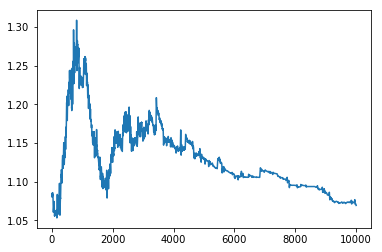

In [65]:
plt.plot(dl)

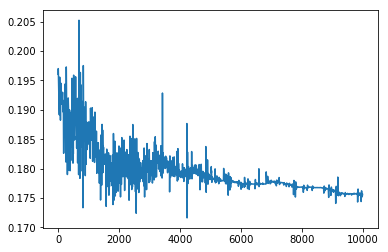

In [66]:
plt.plot(gl)

### Generate pictures

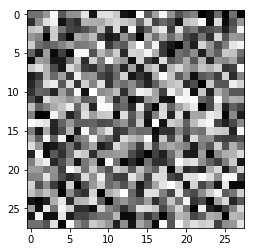

In [82]:
plt.imshow(np.random.rand(28, 28),cmap='gray')

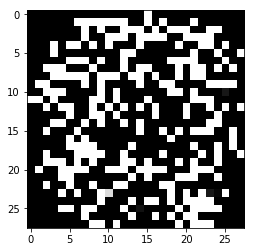

In [74]:
plt.imshow(MLP_G.predict(np.random.rand(1, 100)).reshape(28,28),cmap='gray')


### Overall, it's not generating good image. Let's verify using Convolution in out Generator.

In [75]:
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

### Build CNN Generator and Discriminator

In [93]:
CNN_G = Sequential([
        Dense(512*7*7, input_dim=100, activation = LeakyReLU()),
        BatchNormalization(mode=2),
        Reshape((7, 7, 512)),
        UpSampling2D(),
        # apply a 3x3 convolution with 64 output filters on a image:
        Convolution2D(64, 3, 3, border_mode = 'same', activation = LeakyReLU()),
        BatchNormalization(mode=2),
        UpSampling2D(),
        Convolution2D(32, 3, 3, border_mode = 'same', activation = LeakyReLU()),
        BatchNormalization(mode=2),
        Convolution2D(1, 1, 1, border_mode = 'same', activation = 'sigmoid')
    ])

In [94]:
CNN_G.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_18 (Dense)                 (None, 25088)         2533888     dense_input_6[0][0]              
____________________________________________________________________________________________________
batchnormalization_11 (BatchNorm (None, 25088)         100352      dense_18[0][0]                   
____________________________________________________________________________________________________
reshape_5 (Reshape)              (None, 7, 7, 512)     0           batchnormalization_11[0][0]      
____________________________________________________________________________________________________
upsampling2d_5 (UpSampling2D)    (None, 14, 14, 512)   0           reshape_5[0][0]                  
___________________________________________________________________________________________

In [84]:
CNN_D = Sequential([
        Convolution2D(256, 5, 5, subsample = (2,2), border_mode = 'same', input_shape = (28,28,1), activation = LeakyReLU()),
        Convolution2D(256, 5, 5, subsample = (2,2), border_mode = 'same', activation = LeakyReLU()),
        Flatten(),
        Dense(256, activation = LeakyReLU()),
        Dense(1,activation = 'sigmoid')
    ])
CNN_D.compile(Adam(1e-3), "binary_crossentropy")

In [90]:
CNN_D.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_7 (Convolution2D)  (None, 14, 14, 256)   6656        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 7, 7, 256)     1638656     convolution2d_7[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 12544)         0           convolution2d_8[0][0]            
____________________________________________________________________________________________________
dense_16 (Dense)                 (None, 256)           3211520     flatten_1[0][0]                  
___________________________________________________________________________________________

### Train Discriminator a little bit

In [95]:
size = len(X_train)//200
X_t = np.concatenate((np.random.permutation(X_train)[:size], CNN_G.predict(np.random.rand(size, 100))))
CNN_D.fit(X_t, [0]*size+[1]*size, batch_size=128, nb_epoch=1, verbose=2)

Epoch 1/1
5s - loss: 0.8246


### Combine CNN Generator and Discriminator and train

In [96]:
CNN_m = Sequential([CNN_G, CNN_D])
CNN_m.compile(Adam(1e-4), "binary_crossentropy")

In [149]:
batch_size = 128
#epoch = 1000
epoch = 200
#dl,gl=[],[]

for i in range(epoch):
    X, y = discrimnator_data(CNN_G, batch_size)
    dl.append(CNN_D.train_on_batch(X,y))
    
    # Before we train Generator, freeze Discrimonator
    make_trainable(CNN_D, False)
    gl.append(CNN_m.train_on_batch(np.random.rand(batch_size, 100), np.zeros([batch_size])))
    
    make_trainable(CNN_D, True)

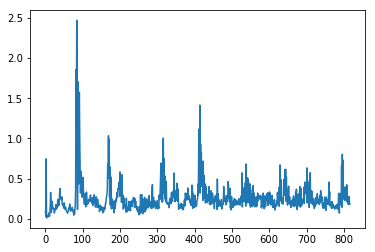

In [150]:
plt.plot(dl)

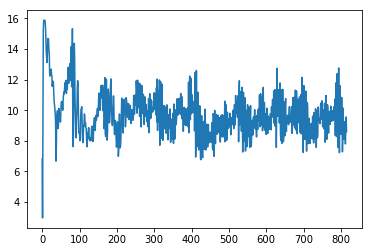

In [151]:
plt.plot(gl)

### Generate pictures

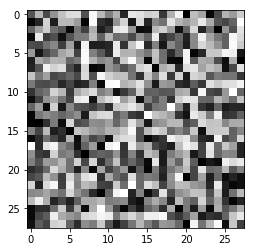

In [152]:
plt.imshow(np.random.rand(28, 28),cmap='gray')

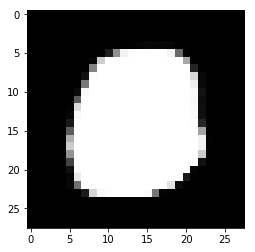

In [153]:
plt.imshow(CNN_G.predict(np.random.rand(1, 100)).reshape(28,28),cmap='gray')

### Not so impressive. But seems bettert then MLP_G.

### Next up, let's try with W-GAN
#### And this time, we will use Pytorch

In [113]:
from torch_utils import *

In [187]:
batch_size, image_size, noise_size = 64,28,100

In [188]:
PATH = 'data/mnist/'
data = datasets.MNIST(root=PATH, download=False,
   transform=transforms.Compose([
       transforms.Scale(image_size),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)

In [190]:
dataloader = torch.utils.data.DataLoader(data, batch_size, True, num_workers=8)

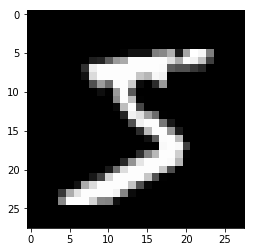

In [189]:
x,y = data[0]
x.shape
plt.imshow(np.squeeze(x.numpy()), cmap='gray')

In [197]:
import dcgan
from dcgan import DCGAN_D, DCGAN_G

### Build DCGAN Generator and Discriminator using Pytorch

In [269]:
ngpu = 0
nz = 100
ngf = 64
ndf = 64
nc = 1
batchSize = 64
imageSize = 64
workers = 2
lr = 0.0002
beta1 = 0.5
niter = 10

outf = 'data/output/'

In [264]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [265]:
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = _netG(ngpu)
netG.apply(weights_init)

_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)

In [266]:
class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = _netD(ngpu)
netD.apply(weights_init)

_netD (
  (main): Sequential (
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid ()
  )
)

In [270]:

PATH = 'data/mnist/'
data = datasets.MNIST(root=PATH, download=False,
   transform=transforms.Compose([
       transforms.Scale(imageSize),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)
dataloader = torch.utils.data.DataLoader(data, batchSize, True, num_workers=8)

In [424]:
data_all = datasets.MNIST(root=PATH, download=False,
   transform=transforms.Compose([
       transforms.Scale(imageSize),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)

i = 0
for xl,yl in data_all:
    print (xl.shape)
    i += 1
    if (i == 10):
        break

torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


0
torch.Size([1, 64, 64])


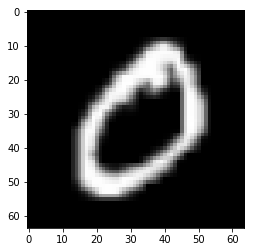

In [271]:
x,y = data[1]
print(y)
print(x.shape)
plt.imshow(np.squeeze(x.numpy()),cmap='gray')

In [272]:
len(dataloader)

938

In [273]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batchSize, 1, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0


fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

### Start Training

In [274]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)

        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        # errD_real is binary cross entropy
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        
        # Total Discriminator error = errD_real + errD_fake
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d_%04d.png' % (outf, epoch, i),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/10][0/938] Loss_D: 1.4476 Loss_G: 2.2613 D(x): 0.4044 D(G(z)): 0.2992 / 0.1323
[0/10][1/938] Loss_D: 2.7581 Loss_G: 3.9045 D(x): 0.9994 D(G(z)): 0.9042 / 0.0325
[0/10][2/938] Loss_D: 1.2096 Loss_G: 6.4637 D(x): 0.9969 D(G(z)): 0.6293 / 0.0028
[0/10][3/938] Loss_D: 0.2829 Loss_G: 7.1224 D(x): 0.9955 D(G(z)): 0.2220 / 0.0013
[0/10][4/938] Loss_D: 0.0947 Loss_G: 6.5574 D(x): 0.9932 D(G(z)): 0.0811 / 0.0022
[0/10][5/938] Loss_D: 0.2812 Loss_G: 6.3169 D(x): 0.9390 D(G(z)): 0.1683 / 0.0027
[0/10][6/938] Loss_D: 0.2868 Loss_G: 7.2034 D(x): 0.9362 D(G(z)): 0.1667 / 0.0013
[0/10][7/938] Loss_D: 0.2846 Loss_G: 7.1897 D(x): 0.9219 D(G(z)): 0.1236 / 0.0012
[0/10][8/938] Loss_D: 0.1941 Loss_G: 7.8569 D(x): 0.9630 D(G(z)): 0.1342 / 0.0007
[0/10][9/938] Loss_D: 0.1219 Loss_G: 7.5335 D(x): 0.9592 D(G(z)): 0.0689 / 0.0009
[0/10][10/938] Loss_D: 0.2073 Loss_G: 8.6258 D(x): 0.9577 D(G(z)): 0.1388 / 0.0003
[0/10][11/938] Loss_D: 0.1254 Loss_G: 7.5588 D(x): 0.9347 D(G(z)): 0.0401 / 0.0011
[0/10][12/938]

Process Process-108:
Process Process-111:
Process Process-109:
Process Process-107:
Process Process-105:
Process Process-106:
Process Process-110:
Process Process-112:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multi

KeyboardInterrupt: 

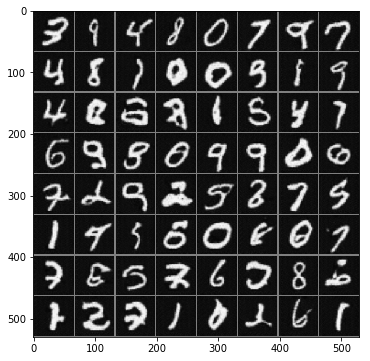

In [275]:
def show(img, fs=(6,6)):
    plt.figure(figsize = fs)
    plt.imshow(np.transpose((img/2+0.5).clamp(0,1).numpy(), (1,2,0)), interpolation='nearest')
    
fake = netG(fixed_noise).data.cpu()
show(vutils.make_grid(fake))

In [277]:
#from images2gif import writeGif


In [309]:
import numpy as np
def convertImg2Array(img):
    return np.array(img.getdata(),np.uint8).reshape(img.size[1], img.size[0], 3)

In [322]:
#coding=utf-8 

import time  
import string  
from PIL import Image, ImageChops  
from PIL.GifImagePlugin import getheader, getdata  
import os  

def intToBin(i):  
    """ 把整型数转换为双字节 """  
    # 先分成两部分,高8位和低8位  
    i1 = i % 256  
    i2 = int( i/256)  
    # 合成小端对齐的字符串  
    return chr(i1) + chr(i2)  
def getheaderAnim(im):  
    """ 生成动画文件头 """  
    bb = "GIF89a"  
    bb += intToBin(im.size[0])  
    bb += intToBin(im.size[1])  
    bb += "\x87\x00\x00"  #使用全局颜色表  
    return bb  
def getAppExt(loops=0):  
    """ 应用扩展,默认为0,为0是表示动画是永不停止 
    """  
    bb = "\x21\xFF\x0B"  # application extension  
    bb += "NETSCAPE2.0"  
    bb += "\x03\x01"  
    if loops == 0:  
        loops = 2**16-1  
    bb += intToBin(loops)  
    bb += '\x00'  # end  
    return bb  


def getGraphicsControlExt(duration=0.1):  
    """ 设置动画时间间隔 """  
    bb = '\x21\xF9\x04'  
    bb += '\x08'  # no transparancy  
    bb += intToBin( int(duration*100) ) # in 100th of seconds  
    bb += '\x00'  # no transparant color  
    bb += '\x00'  # end  
    return bb  
def _writeGifToFile(fp, images, durations, loops):  
    """ 把一系列图像转换为字节并存入文件流中 
    """  
    # 初始化  
    frames = 0  
    previous = None  
    for im in images:  
        if not previous:  
            # 第一个图像  
            # 获取相关数据  
            palette=getheader(im)[0][-1]
            #palette =im.palette.getdata()[1]  #取第一个图像的调色板  
            #print(type(palette))
            data = getdata(im)  
            imdes, data = data[0], data[1:]              
            header = getheaderAnim(im)  
            appext = getAppExt(loops)  
            graphext = getGraphicsControlExt(durations[0])  

            # 写入全局头  
            fp.write(header)  
            fp.write(palette)  
            fp.write(appext)  

            # 写入图像  
            fp.write(graphext)  
            fp.write(imdes)  
            for d in data:  
                fp.write(d)  

        else:  
            # 获取相关数据            
            data = getdata(im)   
            imdes, data = data[0], data[1:]         
            graphext = getGraphicsControlExt(durations[frames])  

            # 写入图像  
            fp.write(graphext)  
            fp.write(imdes)  
            for d in data:  
                fp.write(d)     
        # 准备下一个回合  
        previous = im.copy()          
        frames = frames + 1  

    fp.write(";")  # 写入完成  
    return frames    

def writeGif(filename, images, duration=0.1, loops=0, dither=1):  
    """ writeGif(filename, images, duration=0.1, loops=0, dither=1) 
    从输入的图像序列中创建GIF动画 
    images 是一个PIL Image [] 或者 Numpy Array 
    """  
    images2 = []  
    # 先把图像转换为PIL格式  
    for im in images:  

        if isinstance(im,Image.Image): #如果是PIL Image  
            images2.append( im.convert('P',dither=dither) )  

        elif np and isinstance(im, np.ndarray): #如果是Numpy格式  
            if im.dtype == np.uint8:  
                pass  
            elif im.dtype in [np.float32, np.float64]:  
                im = (im*255).astype(np.uint8)  
            else:  
                im = im.astype(np.uint8)  
            # 转换  
            if len(im.shape)==3 and im.shape[2]==3:  
                im = Image.fromarray(im,'RGB').convert('P',dither=dither)  
            elif len(im.shape)==2:  
                im = Image.fromarray(im,'L').convert('P',dither=dither)  
            else:  
                raise ValueError("图像格式不正确")

            images2.append(im)  

        else:  
            raise ValueError("未知图像格式")  

    # 检查动画播放时间  
    durations = [duration for im in images2]  
    # 打开文件  
    fp = open(filename, 'wb')  
    # 写入GIF  
    try:  
        n = _writeGifToFile(fp, images2, durations, loops)  
    finally:  
        fp.close()  
    return n  

############################################################  
## 将多帧位图合成为一幅gif图像  
def images2gif( images, giffile, durations=0.05, loops = 0):  
    seq = []  
    for i in range(len(images)):  
        im = Image.open(images[i])  
        background = Image.new('RGB', im.size, (255,255,255))  
        background.paste(im, (0,0))
        seq.append(background)  
    frames = writeGif( giffile, seq, durations, loops)  
    print frames, 'images has been merged to', giffile  

In [326]:
file_names = [f for f in os.listdir('data/output/') if f.endswith('.png')]
images = [Image.open('data/output/'+f) for f in file_names] 
writeGif('data/output/output.gif', images, duration=0.1)

IOError: [Errno 24] Too many open files: 'data/output/fake_samples_epoch_003_0700.png'

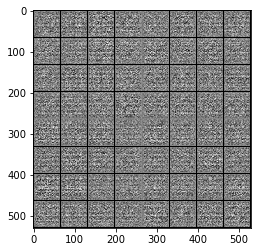

In [293]:
# Visulize the optimization performance
from IPython.display import HTML
from matplotlib import animation, rc
from utils2 import *
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
def animate(i):ax.imshow(Image.open('data/output/fake_samples_epoch_00{i}_0{j}00.png'.format(i=i/10, j=i%10)))

anim = animation.FuncAnimation(fig, animate, frames=80, interval=300)
HTML(anim.to_html5_video())

### Seems to be not bad.Let's try with W-GAN.
#### 1. 判别器最后一层去掉sigmoid
#### 2. 生成器和判别器的loss不取log
#### 3. 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
#### 4. 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp，SGD也行

In [396]:
ngpu = 0
nz = 100
ngf = 64
ndf = 64
nc = 1
batchSize = 64
imageSize = 64
workers = 2
lr = 0.00005
beta1 = 0.5
niter = 5
n_critic = 5

In [397]:
class wgan_netD(nn.Module):
    def __init__(self, ngpu):
        super(wgan_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # WGAN Change -- 判别器最后一层去掉sigmoid
            #nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD_wgan = wgan_netD(ngpu)
netD_wgan.apply(weights_init)


wgan_netD (
  (main): Sequential (
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU (0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (4): LeakyReLU (0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (7): LeakyReLU (0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (10): LeakyReLU (0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)

In [399]:
class wagan_netG(nn.Module):
    def __init__(self, ngpu):
        super(wagan_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG_wgan = wagan_netG(ngpu)
netG_wgan.apply(weights_init)


wagan_netG (
  (main): Sequential (
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (11): ReLU (inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh ()
  )
)

In [400]:

PATH = 'data/mnist/'
data = datasets.MNIST(root=PATH, download=False,
   transform=transforms.Compose([
       transforms.Scale(imageSize),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ])
)
dataloader = torch.utils.data.DataLoader(data, batchSize, True, num_workers=8)

In [401]:

input = torch.FloatTensor(batchSize, 1, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0


fixed_noise = Variable(fixed_noise)

# setup optimizer
# WGAN Change -- 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp
optimizerD = optim.RMSprop(netD_wgan.parameters(), lr = lr)
optimizerG = optim.RMSprop(netG_wgan.parameters(), lr = lr)

In [402]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val



In [403]:
outf = 'data/output/wgan/'
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize D(x) + (1 - D(G(z)))
        ###########################
        
        make_trainable(netD_wgan, True)
        
        # WGAN change -- 判别器训练n_critic次
        n_critic = (100 if (i < 25) or i % 500 == 0 else 5)
        
        for j in range(n_critic):
            # WGAN change -- 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
            for p in netD_wgan.parameters(): 
                p.data.clamp_(-0.01, 0.01)
            
            # train with real
            netD_wgan.zero_grad()
            real_img, _ = data
            batch_size = real_img.size(0)

            input.resize_as_(real_img).copy_(real_img)
            label.resize_(batch_size).fill_(real_label)
            inputv = Variable(input)
            labelv = Variable(label)

            output = netD_wgan(inputv)
            # errD_real is binary cross entropy
            # errD_real = criterion(output, labelv)
            # WGAN change -- 生成器和判别器的loss不取log
            errD_real = output.mean()
            errD_real.backward(labelv)
            D_x = output.data.mean()

            # train with fake
            noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
            noisev = Variable(noise)
            fake = netG_wgan(noisev)
          
            labelv = Variable(label.fill_(fake_label))
            output = netD_wgan(fake.detach())
            # errD_fake = criterion(output, labelv)
            # WGAN change -- 生成器和判别器的loss不取log
            errD_fake = output.mean()
            errD_fake.backward(labelv)
            D_G_z1 = output.data.mean()
        

            # errD = errD_real + errD_fake
            # WGAN change -- 判决器的loss新方法
            # to minimize errD
            errD = errD_fake - errD_real
            Wasserstein_D = (errD_real - errD_fake).data.mean()
            optimizerD.step()

        ############################
        # (2) Update G network: maximize D(G(z))
        ###########################
        make_trainable(netD_wgan, False)
        
        netG_wgan.zero_grad()
        
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG_wgan(noisev)
        output = netD_wgan(fake)
        
        # errG = criterion(output, labelv)
        # WGAN change -- 生成器和判别器的loss不取log
        # to minimize errG
        errG = -(output.mean())
        errG.backward(labelv)
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f WassersteinDistance: %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2, Wasserstein_D))
        if i % 100 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG_wgan(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d_%04d.png' % (outf, epoch, i),
                    normalize=True)

    # do checkpointing
    torch.save(netG_wgan.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netG_wgan.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/5][0/938] Loss_D: 0.0361 Loss_G: 1.0735 D(x): -0.9842 D(G(z)): -0.9481 / -1.0735 WassersteinDistance: -0.0361
[0/5][1/938] Loss_D: 0.1015 Loss_G: 0.9810 D(x): -0.9867 D(G(z)): -0.8851 / -0.9810 WassersteinDistance: -0.1015
[0/5][2/938] Loss_D: 0.1310 Loss_G: 0.9467 D(x): -0.9880 D(G(z)): -0.8570 / -0.9467 WassersteinDistance: -0.1310
[0/5][3/938] Loss_D: 0.1431 Loss_G: 0.9548 D(x): -0.9881 D(G(z)): -0.8450 / -0.9548 WassersteinDistance: -0.1431
[0/5][4/938] Loss_D: 0.1374 Loss_G: 0.9509 D(x): -0.9882 D(G(z)): -0.8508 / -0.9509 WassersteinDistance: -0.1374
[0/5][5/938] Loss_D: 0.1251 Loss_G: 0.9350 D(x): -0.9881 D(G(z)): -0.8629 / -0.9350 WassersteinDistance: -0.1251
[0/5][6/938] Loss_D: 0.1252 Loss_G: 0.9890 D(x): -0.9778 D(G(z)): -0.8526 / -0.9890 WassersteinDistance: -0.1252
[0/5][7/938] Loss_D: 0.1244 Loss_G: 0.9403 D(x): -0.9896 D(G(z)): -0.8653 / -0.9403 WassersteinDistance: -0.1244
[0/5][8/938] Loss_D: 0.1422 Loss_G: 0.9455 D(x): -0.9899 D(G(z)): -0.8477 / -0.9455 WassersteinD

Process Process-227:
Process Process-231:
Process Process-226:
Process Process-225:
Process Process-229:
Process Process-230:
Process Process-228:
Process Process-232:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multi

KeyboardInterrupt: 

#### WGAN training result is a bit frustrating. Let's try training the same DCGAN on CelebA dataset

In [467]:
ngpu = 0
nz = 100
ngf = 64
ndf = 64
nc = 3
batchSize = 64
imageSize = 64
workers = 2
lr = 0.0002
beta1 = 0.5
niter = 50

outf = 'data/output/face/'

In [468]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

data = dset.ImageFolder(root='/Users/edwzhang/Downloads/celeba1/',
       transform=transforms.Compose([
       transforms.Scale((imageSize,imageSize)),
       transforms.ToTensor(),
       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
   ]))

dataloader = torch.utils.data.DataLoader(data, batchSize, True, num_workers=8)

19999
torch.Size([3, 64, 64])


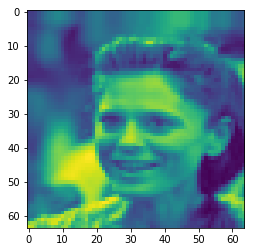

In [470]:
print(len(data))
x,y=data[1]
print(x.shape)
plt.imshow(x[2,:,:].numpy())

In [471]:

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class _netG(nn.Module):
    def __init__(self, ngpu):
        super(_netG, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output


netG = _netG(ngpu)
netG.apply(weights_init)


class _netD(nn.Module):
    def __init__(self, ngpu):
        super(_netD, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if isinstance(input.data, torch.cuda.FloatTensor) and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)


netD = _netD(ngpu)
netD.apply(weights_init)


criterion = nn.BCELoss()

input = torch.FloatTensor(batchSize, 1, imageSize, imageSize)
noise = torch.FloatTensor(batchSize, nz, 1, 1)
fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batchSize)
real_label = 1
fake_label = 0


fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [472]:
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)

        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        # errD_real is binary cross entropy
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        
        # Total Discriminator error = errD_real + errD_fake
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, niter, i, len(dataloader),
                 errD.data[0], errG.data[0], D_x, D_G_z1, D_G_z2))
        if i % 25 == 0:
            vutils.save_image(real_cpu,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data,
                    '%s/fake_samples_epoch_%03d_%04d.png' % (outf, epoch, i),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))

[0/50][0/313] Loss_D: 1.9310 Loss_G: 5.5808 D(x): 0.6005 D(G(z)): 0.6739 / 0.0052
[0/50][1/313] Loss_D: 0.6302 Loss_G: 6.7364 D(x): 0.9122 D(G(z)): 0.3692 / 0.0016
[0/50][2/313] Loss_D: 0.3457 Loss_G: 5.9983 D(x): 0.8600 D(G(z)): 0.1234 / 0.0038
[0/50][3/313] Loss_D: 0.4428 Loss_G: 6.2101 D(x): 0.8989 D(G(z)): 0.2130 / 0.0028
[0/50][4/313] Loss_D: 0.3170 Loss_G: 6.2056 D(x): 0.8961 D(G(z)): 0.1283 / 0.0027
[0/50][5/313] Loss_D: 0.2949 Loss_G: 7.0226 D(x): 0.9300 D(G(z)): 0.1543 / 0.0012
[0/50][6/313] Loss_D: 0.3280 Loss_G: 6.4508 D(x): 0.9103 D(G(z)): 0.0819 / 0.0022
[0/50][7/313] Loss_D: 0.3757 Loss_G: 8.7778 D(x): 0.9562 D(G(z)): 0.2443 / 0.0002
[0/50][8/313] Loss_D: 0.1574 Loss_G: 7.7744 D(x): 0.9128 D(G(z)): 0.0337 / 0.0008
[0/50][9/313] Loss_D: 0.2521 Loss_G: 6.3284 D(x): 0.8888 D(G(z)): 0.0744 / 0.0026
[0/50][10/313] Loss_D: 0.5427 Loss_G: 11.2235 D(x): 0.9459 D(G(z)): 0.3145 / 0.0000
[0/50][11/313] Loss_D: 0.2240 Loss_G: 10.4070 D(x): 0.9289 D(G(z)): 0.0044 / 0.0001
[0/50][12/31

Process Process-440:
Process Process-434:
Process Process-436:
Process Process-435:
Process Process-433:
Process Process-438:
Process Process-437:
Process Process-439:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/Users/edwzhang/anaconda/lib/python2.7/multi

KeyboardInterrupt: 

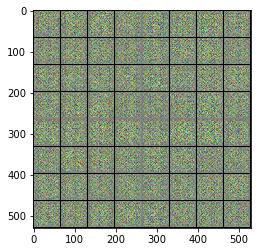

In [486]:
# Visulize the optimization performance
from IPython.display import HTML
from matplotlib import animation, rc
from utils2 import *
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
def animate(i):
    ax.imshow(Image.open('data/output/face/fake_samples_epoch_0{i}_0{j}.png'.
                         format(i=('{:02d}'.format(i/13)),j=('{:03d}'.format((i%13)*25)))))

anim = animation.FuncAnimation(fig, animate, frames=270, interval=100)
HTML(anim.to_html5_video())

In [496]:
file_names = [f for f in os.listdir('data/output/face_gif/') if f.endswith('0000.png')]
images = [Image.open('data/output/face_gif/'+f) for f in file_names] 
writeGif('data/output/face_gif/output.gif', images, duration=0.3)

20